# get optimal params with uncertainty

In [1]:
using DifferentialEquations, Optim,  Measurements

H_data =  [20000,   50000,  80000, 110000, 140000]
P5_data = [measurement(264410.0, 10000.0), measurement(257132.0, 10000.0), measurement(251466.0, 10000.0), measurement(218014.0, 10000.0), measurement(199986.0, 10000.0)]

function P5(H, r, K)  # fish population at end of 5 years
  dudt(u, (r, K, H), t) = u > measurement(0.01,0.01) ? r * u * (K - u) - H : measurement(0.0,0.0)
  prob = ODEProblem(dudt, measurement(200000.0, 10000.0), (0.0, 5.0), (; r, K, H))
  sol = solve(prob, Tsit5())
  max(sol[end][1])
end

# loss function uses scaled versions of r and K
loss(x) = sum(abs2, P5(H, x[1]*1e-5, x[2]*1e5) - y for (H, y) ∈ zip(H_data, P5_data))

# optimize r and K using forward-mode AD
sol = optimize(loss, [measurement(1.5,0.0057),measurement(2.0,0.0076)] )   # , LBFGS(); autodiff=:forward
r, K = Optim.minimizer(sol) .* [1e-5, 1e5]    # rescale r and K

# plot output
#plot(H -> P5(H, r, K), 0, 300000; legend=false, xlabel="H", ylabel="P5")

2-element Vector{Measurement{Float64}}:
 8.992e-6 ± 3.5e-8
 278000.0 ± 1000.0

# calculate for H with 90% confidence level

## MCMC method

In [43]:
using ForwardDiff
using Optim
using MonteCarloMeasurements, Distributions
using DifferentialEquations , Turing
dudt(u, (r, K, H), t) = u > 0.0 ? r * u * (K - u) - H : 0.0

r_dist = Normal(8.992e-6 , 3.5e-8 )
K_dist = Normal(278000.0 , 1000.0)
P_dist = Normal(200000.0, 10000.0)
HH = 140000.0
count_iter = 0
inrange_stock = []

while true
    stock = []
    for i =1:2000
        r = rand(r_dist)
        K = rand(K_dist)
        P0 = rand(P_dist)
        #println(r, K, P0)
        prob = ODEProblem(dudt, P0, (0.0, 5.0), [r,K,HH])
        sol = solve(prob, Tsit5())
        final_population = sol[end][1]
        push!(stock,final_population)
        # println(length(stock))
    end
    
    below_count = count(x -> x < 100000.0, stock)
    #println(below_count)
    
    if below_count > 200  
    # 90% probability that end stock more than 100000
        break
    end
    
    HH += 500
    count_iter +=1
    inrange_stock = stock
end
println( "The Maximum allowable harvest:", HH-500 )
println("iter times:", count_iter-1 )

The Maximum allowable harvest:185500.0
iter times:91


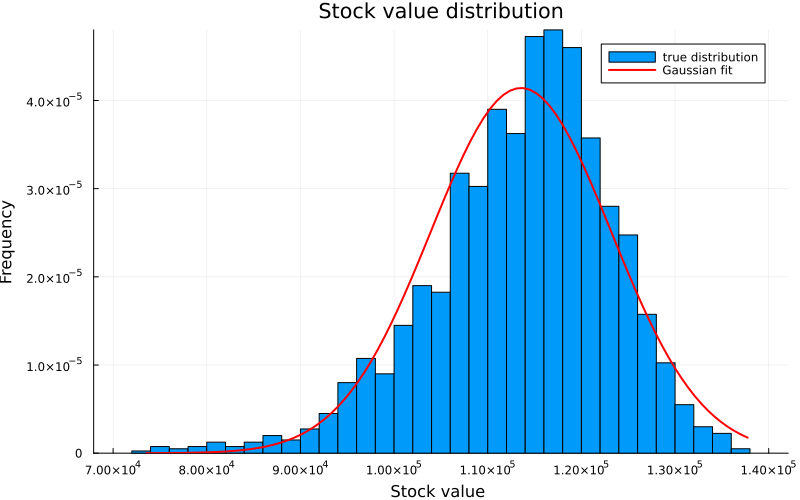

In [46]:
using Statistics # esitmate gaussian
using Plots
μ = mean(inrange_stock)
σ = std(inrange_stock)

# generate normal distribution x
x = range(minimum(inrange_stock), stop=maximum(inrange_stock), length=count_iter )

# conut normal y
y = pdf.(Normal(μ, σ), x)

# plot
histogram(inrange_stock, normalize = true , xlabel="Stock value ", ylabel="Frequency", title="Stock value distribution" , label ="true distribution")
plot!(x, y, label="Gaussian fit", linewidth=2, color=:red , size=(800, 500) )
xticks!(collect( 1e4:10000.0:1.8e5 ) )

In [51]:
using ForwardDiff

dudt(u, (r, K, H), t) = u > 0.0 ? r * u * (K - u) - H : 0.0
prob = ODEProblem(dudt, zeros(5), (0.0, 5.0), zeros(2))
H = 188700.0
stock = 0.0
save=Float64[]
@model function fishery( prob , H   )
    r ~ Normal(8.992e-6 , 3.5e-8 )
    K ~ Normal(278000.0 , 1000.0)
    P ~ Normal(200000.0, 10000.0)
    #### need change
    sol = solve(prob , Tsit5(); u0= P , p=[r, K , H], saveat= (0.0 , 5.0)  )
    #println("solve once ")
    new_stock ~ Normal(real( sol.u[end] ) ,1000.0 )
    #println(typeof( sol.u[end]) )
    #if typeof( sol.u[end][1]) == Float64
    #    append!(save ,  sol.u[end]  )
    #else
    #    solu_whole = sol.u[end][1]
    #    append!(save ,  ForwardDiff.value(solu_whole ))
    #    println(ForwardDiff.value(solu_whole )  )
    #end
end
chains = sample(fishery(prob, H ), NUTS(0.6 ) ,100 )
MCMCstock = chains[:new_stock]
count_i = count(x -> x < 100000.0, save)


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\12\.julia\packages\SciMLBase\NjslX\src\integrator_interface.jl:600
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\12\.julia\packages\SciMLBase\NjslX\src\integrator_interface.jl:600
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), yo

0